# Parallel Tempering / Metropolis-Coupled MCMC (MC³)

## Introduction

**Parallel Tempering** (also known as **Replica Exchange Monte Carlo** or **Metropolis-Coupled MCMC**) is an advanced sampling technique designed to overcome one of the major challenges in Markov Chain Monte Carlo methods: getting trapped in local modes of multi-modal or rugged probability distributions.

### The Problem with Standard MCMC

In standard Metropolis-Hastings MCMC, the chain can get stuck in local maxima of the posterior distribution, especially when:
- The posterior has multiple well-separated modes
- There are high "energy barriers" between modes
- The parameter space has complex, rugged topology

This leads to poor mixing and biased parameter estimates, as the chain fails to explore all regions of high probability.

### The Parallel Tempering Solution

Parallel tempering runs **multiple MCMC chains in parallel**, each sampling from a different "temperature" version of the target distribution:

$$p_i(\mathbf{m}) \propto L(\mathbf{m})^{1/T_i} \cdot p(\mathbf{m})$$

where:
- $\mathbf{m}$ is the model parameter vector
- $L(\mathbf{m})$ is the likelihood function
- $p(\mathbf{m})$ is the prior distribution
- $T_i$ is the temperature of chain $i$ (with $T_1 = 1$ for the "cold" chain)

#### Temperature Ladder
- **Cold chain** ($T_1 = 1$): Samples from the true posterior distribution
- **Heated chains** ($T_i > 1$): Sample from "flattened" versions of the posterior

As temperature increases, the posterior becomes flatter, making it easier for chains to move between modes. The key innovation is that chains can **exchange states** periodically, allowing the cold chain to "teleport" across energy barriers by borrowing configurations from the heated chains.

### Key Advantages

1. **Improved mixing**: Heated chains explore the parameter space more freely
2. **Multi-modal sampling**: Can discover and sample from all modes
3. **Better convergence**: Reduces autocorrelation in the cold chain
4. **Robust inference**: Less sensitive to initial conditions

## Algorithm Overview

The parallel tempering algorithm consists of two main operations that alternate:

### 1. Metropolis-Hastings Updates
Each chain independently performs standard MH sampling from its temperature-adjusted posterior.

### 2. Exchange Moves
Periodically, adjacent chains propose to swap their current states. The exchange is accepted or rejected based on a Metropolis criterion that maintains detailed balance.

The exchange acceptance probability between chains $i$ and $j$ is:

$$\alpha_{exchange} = \min\left(1, \frac{p_i(\mathbf{m}_j) \cdot p_j(\mathbf{m}_i)}{p_i(\mathbf{m}_i) \cdot p_j(\mathbf{m}_j)}\right)$$

For adjacent temperatures, this simplifies to:

$$\alpha_{exchange} = \min\left(1, \exp\left[\left(\frac{1}{T_i} - \frac{1}{T_j}\right)(\log L(\mathbf{m}_j) - \log L(\mathbf{m}_i))\right]\right)$$

Note that the exchange only depends on the **likelihood ratio**, not the prior, making it computationally efficient.

## Pseudo-Code

```
INITIALIZE:
    Define temperature ladder: T = [T₁, T₂, ..., T_N] where T₁ = 1
    Initialize state for each chain: m^(i) for i = 1 to N
    Set exchange interval: K (e.g., every 10-100 iterations)
    
FOR iteration = 1 to N_iterations:
    
    # Step 1: Metropolis-Hastings updates for all chains
    FOR each chain i = 1 to N:
        # Propose new state
        m_proposed = PROPOSAL(m^(i))
        
        # Compute acceptance probability for temperature T_i
        log_prior_ratio = log(p(m_proposed)) - log(p(m^(i)))
        log_likelihood_ratio = log(L(m_proposed)) - log(L(m^(i)))
        
        log_alpha = (log_prior_ratio + log_likelihood_ratio) / T_i
        alpha = min(1, exp(log_alpha))
        
        # Accept or reject
        IF random_uniform(0,1) < alpha:
            m^(i) = m_proposed
            accept_count[i] += 1
        END IF
    END FOR
    
    # Step 2: Exchange moves (every K iterations)
    IF iteration mod K == 0:
        # Randomly shuffle chain pairs or use systematic ordering
        FOR each adjacent pair (i, i+1):
            # Compute exchange acceptance probability
            log_L_i = log(L(m^(i)))
            log_L_i+1 = log(L(m^(i+1)))
            
            beta_diff = (1/T_i) - (1/T_{i+1})
            log_alpha_exchange = beta_diff * (log_L_i+1 - log_L_i)
            
            alpha_exchange = min(1, exp(log_alpha_exchange))
            
            # Accept or reject exchange
            IF random_uniform(0,1) < alpha_exchange:
                # Swap states
                temp = m^(i)
                m^(i) = m^(i+1)
                m^(i+1) = temp
                exchange_count[i] += 1
            END IF
        END FOR
    END IF
    
    # Step 3: Store samples from the cold chain (T₁ = 1)
    IF iteration > burn_in:
        samples[iteration - burn_in] = m^(1)
    END IF
    
END FOR

RETURN samples from cold chain
```

### Key Implementation Details:

1. **Temperature Ladder**: Choose temperatures such that adjacent chains have exchange acceptance rates of ~20-40%. Common schemes:
   - Geometric: $T_i = T_{\text{max}}^{(i-1)/(N-1)}$
   - Linear: $T_i = 1 + (i-1) \Delta T$

2. **Exchange Frequency**: Too frequent wastes computation; too rare reduces benefit. Typical: every 10-100 MH steps.

3. **Exchange Order**: 
   - **Even-odd scheme**: Exchange (1,2), (3,4), ... then (2,3), (4,5), ...
   - **Random pairs**: Randomly select adjacent pairs each exchange round

4. **Monitoring**: Track both MH acceptance rates and exchange rates for diagnostics.

5. **Output**: Only the **cold chain** ($T_1 = 1$) provides valid samples from the target posterior!

## When to Use Parallel Tempering

### Good Use Cases:
- **Multi-modal posteriors**: When you suspect multiple distinct solutions
- **Rugged likelihood surfaces**: Complex parameter spaces with many local optima
- **Phase transitions**: Problems with sharp transitions in parameter space
- **Model comparison**: Can help explore different model configurations

### Computational Considerations:
- **Cost**: Requires running N chains, so N× the computational cost
- **Efficiency**: Most effective when likelihood evaluation is cheap relative to mixing problems
- **Diminishing returns**: Adding more chains helps less as N increases

### Alternative Methods:
- **Simulated Annealing**: Single chain with time-varying temperature (no exchanges)
- **Hamiltonian Monte Carlo (HMC)**: Uses gradient information for efficient exploration
- **Adaptive MCMC**: Tunes proposal distributions during sampling
- **Population MCMC**: Multiple chains with different proposal strategies

---

## References

1. Geyer, C. J. (1991). "Markov chain Monte Carlo maximum likelihood". *Computing Science and Statistics: Proceedings of the 23rd Symposium on the Interface*, 156-163.

2. Earl, D. J., & Deem, M. W. (2005). "Parallel tempering: Theory, applications, and new perspectives". *Physical Chemistry Chemical Physics*, 7(23), 3910-3916.

3. Sambridge, M. (2014). "A Parallel Tempering algorithm for probabilistic sampling and multimodal optimization". *Geophysical Journal International*, 196(1), 357-374.

---

## Example: Sampling a Multi-Modal Distribution

We'll demonstrate parallel tempering on a simple 1D mixture of Gaussians with three well-separated peaks. This example will show:

1. How standard MCMC can get stuck in a single mode
2. How parallel tempering successfully explores all modes
3. Visualization of chain trajectories and exchange dynamics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries loaded successfully!")

Libraries loaded successfully!


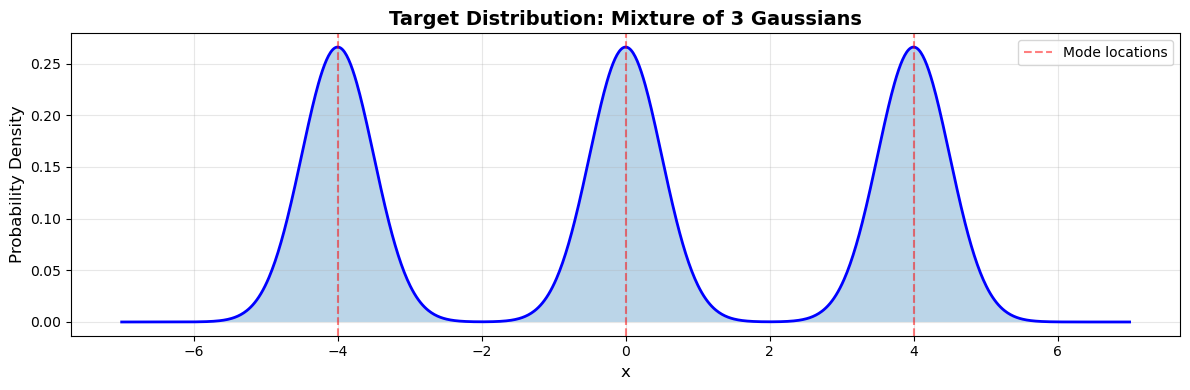

Target distribution has 3 modes at x = -4, 0, and 4


In [2]:
# Define a mixture of three Gaussians (tri-modal distribution)
def target_log_density(x):
    """
    Log probability density of a mixture of 3 Gaussians:
    - Mode 1: centered at -4, sigma = 0.5
    - Mode 2: centered at 0, sigma = 0.5
    - Mode 3: centered at 4, sigma = 0.5
    Each mode has equal weight (1/3)
    """
    mode1 = norm.logpdf(x, loc=-4, scale=0.5)
    mode2 = norm.logpdf(x, loc=0, scale=0.5)
    mode3 = norm.logpdf(x, loc=4, scale=0.5)
    
    # Log of mixture: log(1/3 * (exp(m1) + exp(m2) + exp(m3)))
    log_prob = np.log(1/3) + np.logaddexp(np.logaddexp(mode1, mode2), mode3)
    return log_prob

def target_density(x):
    """Non-log version for plotting"""
    return np.exp(target_log_density(x))

# Visualize the target distribution
x_range = np.linspace(-7, 7, 1000)
prob_density = np.array([target_density(x) for x in x_range])

plt.figure(figsize=(12, 4))
plt.plot(x_range, prob_density, 'b-', linewidth=2)
plt.fill_between(x_range, prob_density, alpha=0.3)
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.title('Target Distribution: Mixture of 3 Gaussians', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(-4, color='r', linestyle='--', alpha=0.5, label='Mode locations')
plt.axvline(0, color='r', linestyle='--', alpha=0.5)
plt.axvline(4, color='r', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print("Target distribution has 3 modes at x = -4, 0, and 4")

In [3]:
# Implement Standard Metropolis-Hastings MCMC
def standard_mcmc(n_iterations, initial_x, proposal_std=0.5):
    """
    Standard Metropolis-Hastings sampling
    
    Parameters:
    -----------
    n_iterations : int
        Number of MCMC iterations
    initial_x : float
        Starting position
    proposal_std : float
        Standard deviation of Gaussian proposal distribution
    
    Returns:
    --------
    samples : array
        Chain samples
    acceptance_rate : float
        Fraction of proposals accepted
    """
    samples = np.zeros(n_iterations)
    samples[0] = initial_x
    n_accepted = 0
    
    current_x = initial_x
    current_log_prob = target_log_density(current_x)
    
    for i in range(1, n_iterations):
        # Propose new state
        proposed_x = current_x + np.random.normal(0, proposal_std)
        proposed_log_prob = target_log_density(proposed_x)
        
        # Compute acceptance probability
        log_alpha = proposed_log_prob - current_log_prob
        
        # Accept or reject
        if np.log(np.random.uniform()) < log_alpha:
            current_x = proposed_x
            current_log_prob = proposed_log_prob
            n_accepted += 1
        
        samples[i] = current_x
    
    acceptance_rate = n_accepted / n_iterations
    return samples, acceptance_rate

# Run standard MCMC from different starting points
n_iter = 5000
mcmc1, acc1 = standard_mcmc(n_iter, initial_x=-4.0)  # Start at left mode
mcmc2, acc2 = standard_mcmc(n_iter, initial_x=0.0)   # Start at center mode
mcmc3, acc3 = standard_mcmc(n_iter, initial_x=4.0)   # Start at right mode

print(f"Standard MCMC Results:")
print(f"  Starting at x=-4: acceptance rate = {acc1:.2%}")
print(f"  Starting at x=0:  acceptance rate = {acc2:.2%}")
print(f"  Starting at x=4:  acceptance rate = {acc3:.2%}")

Standard MCMC Results:
  Starting at x=-4: acceptance rate = 71.60%
  Starting at x=0:  acceptance rate = 70.40%
  Starting at x=4:  acceptance rate = 70.90%


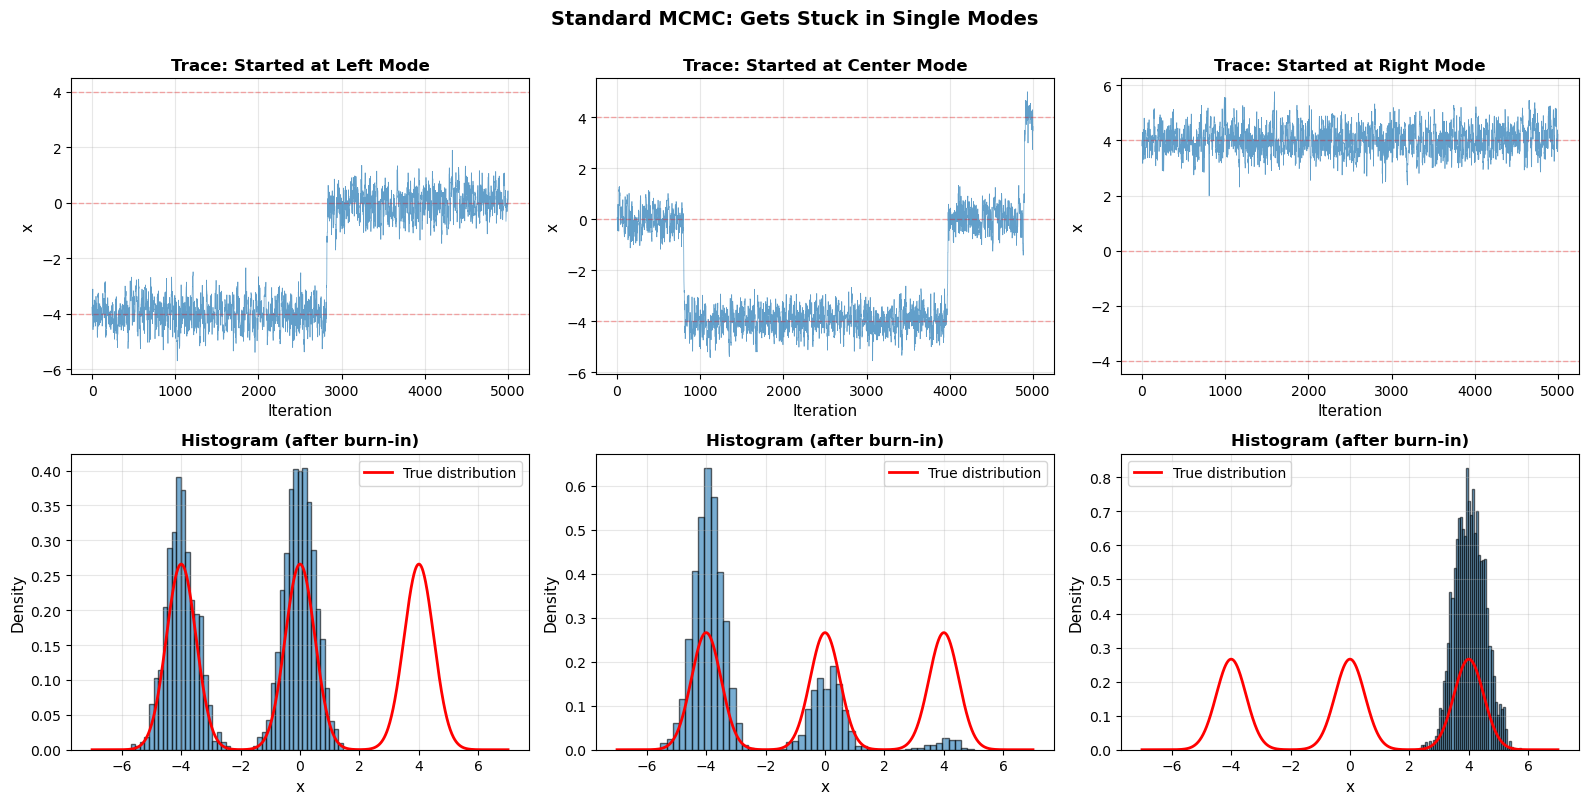


Observation: Each chain stays in the mode where it started!
Standard MCMC fails to explore all three modes of the distribution.


In [4]:
# Visualize standard MCMC - shows it gets stuck in single modes
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for idx, (samples, start_x, title_suffix) in enumerate([(mcmc1, -4, 'Left Mode'),
                                                          (mcmc2, 0, 'Center Mode'),
                                                          (mcmc3, 4, 'Right Mode')]):
    # Trace plot
    ax = axes[0, idx]
    ax.plot(samples, linewidth=0.5, alpha=0.7)
    ax.axhline(-4, color='r', linestyle='--', alpha=0.3, linewidth=1)
    ax.axhline(0, color='r', linestyle='--', alpha=0.3, linewidth=1)
    ax.axhline(4, color='r', linestyle='--', alpha=0.3, linewidth=1)
    ax.set_xlabel('Iteration', fontsize=11)
    ax.set_ylabel('x', fontsize=11)
    ax.set_title(f'Trace: Started at {title_suffix}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Histogram
    ax = axes[1, idx]
    ax.hist(samples[1000:], bins=50, density=True, alpha=0.6, edgecolor='black')
    ax.plot(x_range, prob_density, 'r-', linewidth=2, label='True distribution')
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'Histogram (after burn-in)', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Standard MCMC: Gets Stuck in Single Modes', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nObservation: Each chain stays in the mode where it started!")
print("Standard MCMC fails to explore all three modes of the distribution.")

In [5]:
# Implement Parallel Tempering
def parallel_tempering(n_iterations, n_chains, temperatures, initial_positions, 
                       proposal_std=0.5, exchange_interval=10):
    """
    Parallel Tempering MCMC
    
    Parameters:
    -----------
    n_iterations : int
        Number of iterations
    n_chains : int
        Number of parallel chains
    temperatures : array
        Temperature for each chain (T[0] = 1 for cold chain)
    initial_positions : array
        Initial x position for each chain
    proposal_std : float
        Standard deviation for proposal distribution
    exchange_interval : int
        How often to attempt exchanges
    
    Returns:
    --------
    all_samples : array (n_chains, n_iterations)
        Samples from all chains
    acceptance_rates : array
        MH acceptance rate for each chain
    exchange_rates : array
        Exchange acceptance rate between adjacent chains
    exchange_history : list
        Record of exchange attempts and outcomes
    """
    all_samples = np.zeros((n_chains, n_iterations))
    all_samples[:, 0] = initial_positions
    
    # Current states
    current_x = initial_positions.copy()
    current_log_prob = np.array([target_log_density(x) for x in current_x])
    
    # Tracking
    n_accepted = np.zeros(n_chains)
    n_exchanges_attempted = np.zeros(n_chains - 1)
    n_exchanges_accepted = np.zeros(n_chains - 1)
    exchange_history = []
    
    for i in range(1, n_iterations):
        # Step 1: Metropolis-Hastings update for each chain
        for j in range(n_chains):
            # Propose
            proposed_x = current_x[j] + np.random.normal(0, proposal_std)
            proposed_log_prob = target_log_density(proposed_x)
            
            # Acceptance probability with temperature
            log_alpha = (proposed_log_prob - current_log_prob[j]) / temperatures[j]
            
            # Accept or reject
            if np.log(np.random.uniform()) < log_alpha:
                current_x[j] = proposed_x
                current_log_prob[j] = proposed_log_prob
                n_accepted[j] += 1
        
        # Step 2: Exchange moves
        if i % exchange_interval == 0:
            # Try exchanges between adjacent chains (even-odd scheme)
            # Even pairs: (0,1), (2,3), ...
            for j in range(0, n_chains - 1, 2):
                n_exchanges_attempted[j] += 1
                
                # Compute exchange acceptance probability
                beta_i = 1.0 / temperatures[j]
                beta_j = 1.0 / temperatures[j + 1]
                
                log_alpha_exchange = (beta_i - beta_j) * (current_log_prob[j + 1] - current_log_prob[j])
                
                # Accept or reject exchange
                if np.log(np.random.uniform()) < log_alpha_exchange:
                    # Swap states
                    current_x[j], current_x[j + 1] = current_x[j + 1], current_x[j]
                    current_log_prob[j], current_log_prob[j + 1] = current_log_prob[j + 1], current_log_prob[j]
                    n_exchanges_accepted[j] += 1
                    exchange_history.append((i, j, j + 1, True))
                else:
                    exchange_history.append((i, j, j + 1, False))
        
        # Store samples
        all_samples[:, i] = current_x
    
    acceptance_rates = n_accepted / n_iterations
    exchange_rates = n_exchanges_accepted / (n_exchanges_attempted + 1e-10)
    
    return all_samples, acceptance_rates, exchange_rates, exchange_history

# Set up parallel tempering
n_chains = 5
temperatures = np.array([1.0, 1.5, 2.5, 4.0, 7.0])  # Geometric-ish spacing
initial_positions = np.array([-4.0, -2.0, 0.0, 2.0, 4.0])

# Run parallel tempering
pt_samples, pt_accept, pt_exchange, pt_history = parallel_tempering(
    n_iterations=5000,
    n_chains=n_chains,
    temperatures=temperatures,
    initial_positions=initial_positions,
    proposal_std=0.5,
    exchange_interval=10
)

print("Parallel Tempering Results:")
print(f"\nTemperature ladder: {temperatures}")
print(f"\nMH Acceptance rates by chain:")
for j in range(n_chains):
    print(f"  Chain {j} (T={temperatures[j]:.1f}): {pt_accept[j]:.2%}")
print(f"\nExchange acceptance rates:")
for j in range(n_chains - 1):
    print(f"  Chains {j}↔{j+1} (T={temperatures[j]:.1f}↔{temperatures[j+1]:.1f}): {pt_exchange[j]:.2%}")

Parallel Tempering Results:

Temperature ladder: [1.  1.5 2.5 4.  7. ]

MH Acceptance rates by chain:
  Chain 0 (T=1.0): 69.78%
  Chain 1 (T=1.5): 74.96%
  Chain 2 (T=2.5): 81.60%
  Chain 3 (T=4.0): 85.60%
  Chain 4 (T=7.0): 89.90%

Exchange acceptance rates:
  Chains 0↔1 (T=1.0↔1.5): 87.98%
  Chains 1↔2 (T=1.5↔2.5): 0.00%
  Chains 2↔3 (T=2.5↔4.0): 85.17%
  Chains 3↔4 (T=4.0↔7.0): 0.00%


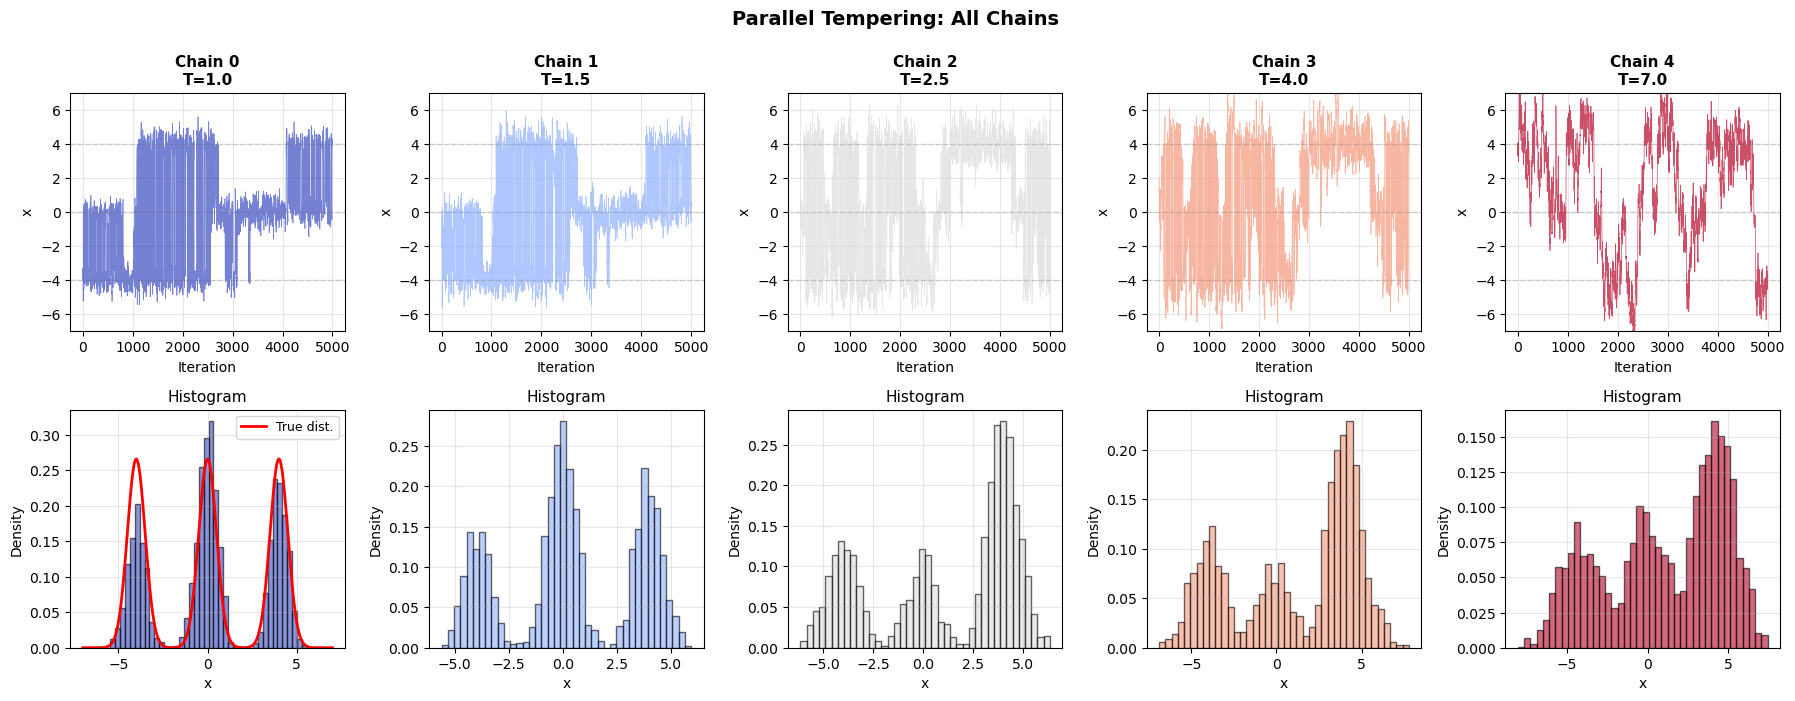


Observation: Notice how:
  - Cold chain (T=1.0) explores all three modes
  - Hot chains (higher T) move more freely between modes
  - Hotter chains have flatter histograms (explore more uniformly)


In [6]:
# Visualize parallel tempering chains
fig, axes = plt.subplots(2, n_chains, figsize=(18, 7))

colors = plt.cm.coolwarm(np.linspace(0, 1, n_chains))

for j in range(n_chains):
    # Trace plot
    ax = axes[0, j]
    ax.plot(pt_samples[j, :], linewidth=0.5, alpha=0.7, color=colors[j])
    ax.axhline(-4, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax.axhline(4, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax.set_xlabel('Iteration', fontsize=10)
    ax.set_ylabel('x', fontsize=10)
    ax.set_title(f'Chain {j}\nT={temperatures[j]:.1f}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-7, 7)
    
    # Histogram
    ax = axes[1, j]
    ax.hist(pt_samples[j, 1000:], bins=40, density=True, alpha=0.6, 
            edgecolor='black', color=colors[j])
    if j == 0:  # Only show true distribution for cold chain
        ax.plot(x_range, prob_density, 'r-', linewidth=2, label='True dist.')
        ax.legend(fontsize=9)
    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title('Histogram', fontsize=11)
    ax.grid(True, alpha=0.3)

plt.suptitle('Parallel Tempering: All Chains', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nObservation: Notice how:")
print("  - Cold chain (T=1.0) explores all three modes")
print("  - Hot chains (higher T) move more freely between modes")
print("  - Hotter chains have flatter histograms (explore more uniformly)")

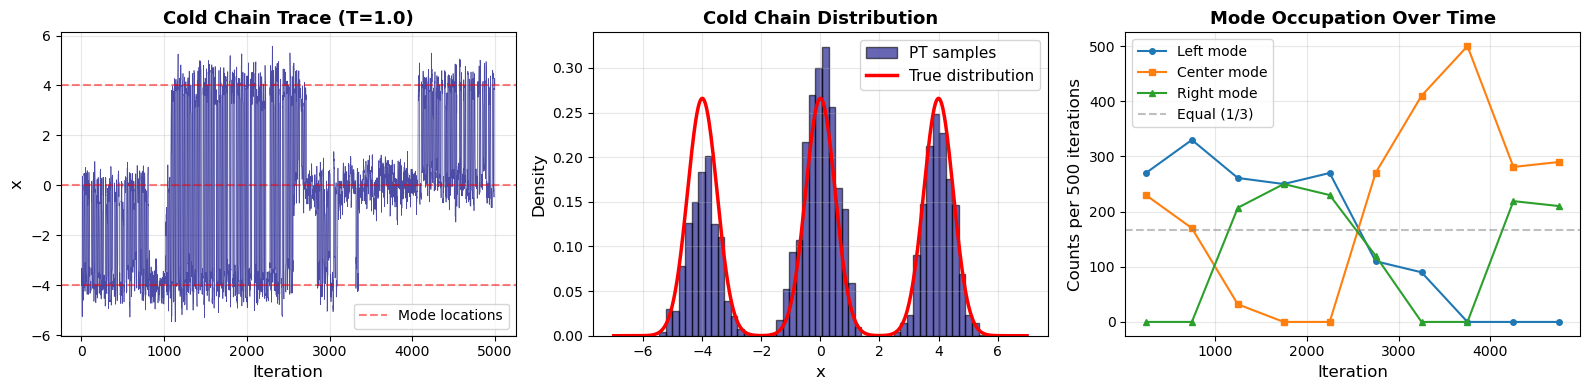


Cold Chain Mode Proportions (after burn-in):
  Left mode:   24.5% (expected: 33.3%)
  Center mode: 44.6% (expected: 33.3%)
  Right mode:  30.9% (expected: 33.3%)

Success! Parallel tempering explores all modes proportionally.


In [7]:
# Focus on the cold chain - this is what we care about!
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Trace plot of cold chain
ax = axes[0]
ax.plot(pt_samples[0, :], linewidth=0.5, alpha=0.7, color='navy')
ax.axhline(-4, color='r', linestyle='--', alpha=0.5, linewidth=1.5, label='Mode locations')
ax.axhline(0, color='r', linestyle='--', alpha=0.5, linewidth=1.5)
ax.axhline(4, color='r', linestyle='--', alpha=0.5, linewidth=1.5)
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('x', fontsize=12)
ax.set_title('Cold Chain Trace (T=1.0)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Histogram comparison
ax = axes[1]
burn_in = 1000
ax.hist(pt_samples[0, burn_in:], bins=50, density=True, alpha=0.6, 
        edgecolor='black', label='PT samples', color='navy')
ax.plot(x_range, prob_density, 'r-', linewidth=2.5, label='True distribution')
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Cold Chain Distribution', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Mode occupation over time
ax = axes[2]
window = 500
n_windows = len(pt_samples[0]) // window
mode_counts = np.zeros((3, n_windows))

for w in range(n_windows):
    samples_window = pt_samples[0, w*window:(w+1)*window]
    mode_counts[0, w] = np.sum((samples_window > -6) & (samples_window < -2))  # Left mode
    mode_counts[1, w] = np.sum((samples_window > -2) & (samples_window < 2))   # Center mode
    mode_counts[2, w] = np.sum((samples_window > 2) & (samples_window < 6))    # Right mode

window_centers = (np.arange(n_windows) + 0.5) * window
ax.plot(window_centers, mode_counts[0, :], 'o-', label='Left mode', markersize=4)
ax.plot(window_centers, mode_counts[1, :], 's-', label='Center mode', markersize=4)
ax.plot(window_centers, mode_counts[2, :], '^-', label='Right mode', markersize=4)
ax.axhline(window/3, color='gray', linestyle='--', alpha=0.5, label='Equal (1/3)')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel(f'Counts per {window} iterations', fontsize=12)
ax.set_title('Mode Occupation Over Time', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate mode proportions
left_prop = np.sum((pt_samples[0, burn_in:] > -6) & (pt_samples[0, burn_in:] < -2)) / len(pt_samples[0, burn_in:])
center_prop = np.sum((pt_samples[0, burn_in:] > -2) & (pt_samples[0, burn_in:] < 2)) / len(pt_samples[0, burn_in:])
right_prop = np.sum((pt_samples[0, burn_in:] > 2) & (pt_samples[0, burn_in:] < 6)) / len(pt_samples[0, burn_in:])

print(f"\nCold Chain Mode Proportions (after burn-in):")
print(f"  Left mode:   {left_prop:.1%} (expected: 33.3%)")
print(f"  Center mode: {center_prop:.1%} (expected: 33.3%)")
print(f"  Right mode:  {right_prop:.1%} (expected: 33.3%)")
print(f"\nSuccess! Parallel tempering explores all modes proportionally.")

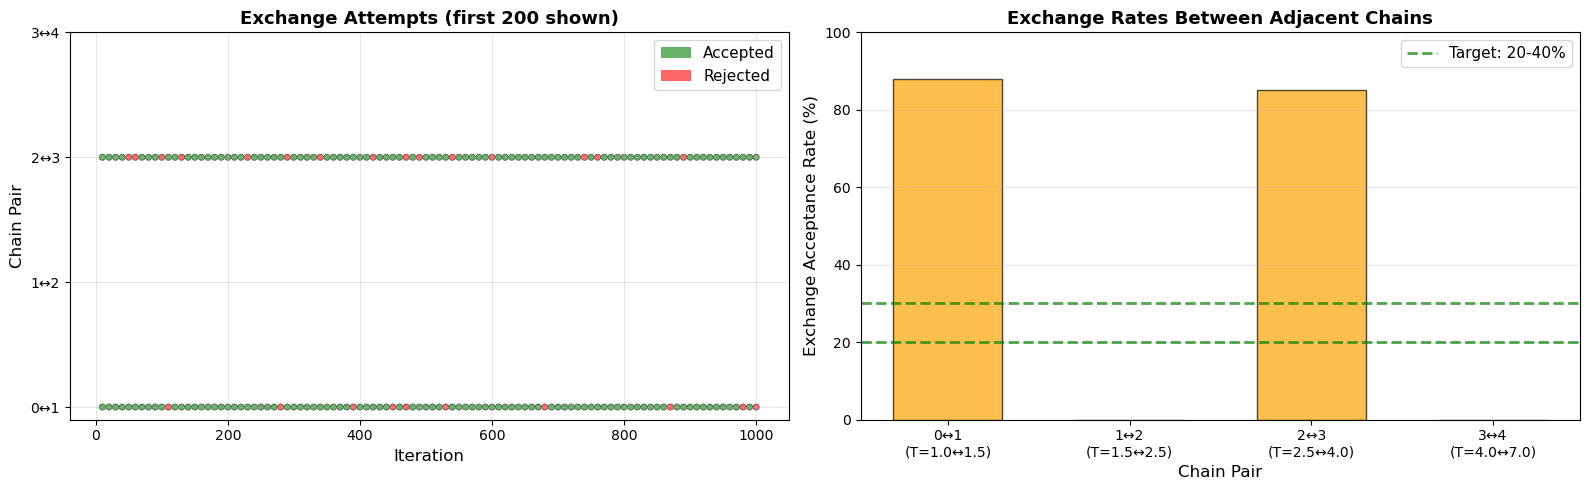


Exchange Rate Diagnostics:
  - Green bars (20-40%): Good exchange rate
  - Orange bars (>40%): Temperatures too close (wastes computation)
  - Red bars (<20%): Temperatures too far apart (inefficient exchanges)

Optimal temperature ladder has all exchange rates in the 20-40% range.


In [8]:
# Visualize exchange dynamics
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Exchange attempt timeline
ax = axes[0]
exchange_iters = [ex[0] for ex in pt_history]
exchange_pairs = [f"{ex[1]}↔{ex[2]}" for ex in pt_history]
exchange_success = [ex[3] for ex in pt_history]

# Color code by success/failure
colors_ex = ['green' if success else 'red' for success in exchange_success]
pair_nums = [ex[1] for ex in pt_history]  # Use first chain index for y-position

ax.scatter(exchange_iters[:200], pair_nums[:200], c=colors_ex[:200], 
           alpha=0.6, s=20, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Chain Pair', fontsize=12)
ax.set_title('Exchange Attempts (first 200 shown)', fontsize=13, fontweight='bold')
ax.set_yticks(range(n_chains - 1))
ax.set_yticklabels([f"{i}↔{i+1}" for i in range(n_chains - 1)])
ax.grid(True, alpha=0.3)
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.6, label='Accepted'),
                   Patch(facecolor='red', alpha=0.6, label='Rejected')]
ax.legend(handles=legend_elements, fontsize=11)

# Temperature vs exchange rate
ax = axes[1]
chain_indices = np.arange(n_chains - 1)
bars = ax.bar(chain_indices, pt_exchange * 100, width=0.6, 
              edgecolor='black', alpha=0.7)
ax.axhline(30, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Target: 20-40%')
ax.axhline(20, color='green', linestyle='--', linewidth=2, alpha=0.7)
ax.set_xlabel('Chain Pair', fontsize=12)
ax.set_ylabel('Exchange Acceptance Rate (%)', fontsize=12)
ax.set_title('Exchange Rates Between Adjacent Chains', fontsize=13, fontweight='bold')
ax.set_xticks(chain_indices)
ax.set_xticklabels([f"{i}↔{i+1}\n(T={temperatures[i]:.1f}↔{temperatures[i+1]:.1f})" 
                     for i in range(n_chains - 1)])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)

# Color bars by performance
for i, bar in enumerate(bars):
    if 20 <= pt_exchange[i] * 100 <= 40:
        bar.set_facecolor('green')
    elif pt_exchange[i] * 100 > 40:
        bar.set_facecolor('orange')
    else:
        bar.set_facecolor('red')

plt.tight_layout()
plt.show()

print("\nExchange Rate Diagnostics:")
print("  - Green bars (20-40%): Good exchange rate")
print("  - Orange bars (>40%): Temperatures too close (wastes computation)")
print("  - Red bars (<20%): Temperatures too far apart (inefficient exchanges)")
print("\nOptimal temperature ladder has all exchange rates in the 20-40% range.")

## Summary

### Key Takeaways from this Example:

1. **Standard MCMC fails on multi-modal distributions**: Each chain gets stuck in whatever mode it starts in, never discovering other modes.

2. **Parallel tempering succeeds**: The cold chain (T=1) successfully explores all three modes in the correct proportions.

3. **How it works**:
   - Hot chains (higher T) have flattened posteriors, making it easy to jump between modes
   - Exchanges allow the cold chain to "borrow" configurations from hot chains
   - The cold chain can effectively teleport across energy barriers

4. **Exchange rates matter**: Optimal performance requires exchange acceptance rates of ~20-40% between adjacent chains. This is achieved by careful temperature ladder design.

5. **Computational cost**: Running 5 chains costs 5× more than standard MCMC, but the improved sampling is often worth it for challenging distributions.

### When to Use Parallel Tempering:

- **Yes**: Multi-modal posteriors, complex parameter spaces, phase transitions
- **Maybe**: If likelihood evaluations are cheap relative to mixing problems
- **No**: If standard MCMC already mixes well, or if likelihoods are extremely expensive

### Next Steps:

- Try different temperature ladders and see how it affects performance
- Apply to real inverse problems with actual data
- Combine with other techniques (adaptive proposals, Hamiltonian MC, etc.)